# Introduction to phylogenetic comparative methods in R
Goettingen 2023  
Andrew Hipp, ahipp@mortonarb.org  
Tutorial 02b: Generalized least squares  
Use [static view in nbviewer](https://nbviewer.org/github/andrew-hipp/workshops/blob/master/2023-goettingen/Wk2-regressions/02b.GLS.ipynb) if you are not working directly in Jupyter notebooks.

# Session 2b: Phylogenetic generalized least squares (GLS)

## OLS vs GLS: the covariance matrix
When we perform linear regression, we generally use what is referred to as an ordinary least squares (OLS) estimator for the regression coefficients (which include the intercept, if you choose to estimate it, as well as the slope on each predictor variable) as well as the model variance. These are our model parameters. With OLS, we assume that the residuals of our regression are independent of one another and normally distributed. Generalized least squares (GLS) allows us to relax this assumption: data (and residuals) may be correlated and have unequal variances. 

PIC relaxes these assumptions by transforming the tip data into contrasts, which have an expectation of 0; and normalizing those contrasts by their expected variance, so that data points that might drift off into new values don't disproportionately influence results. PIC is, thus, a kind of weighted regression.

GLS is as well. GLS uses the inverted phylogenetic variance-covariance matrix (or simply covariance matrix, or sometimes variance matrix) to weight the data. The covariance matrix is abbreviated __C__, and the inverted matrix, __C__<sup>-1</sup>. You'll see what these look like below. In case you are left wanting more, see [tutorial 02c](https://github.com/andrew-hipp/workshops/blob/master/2023-goettingen/Wk2-regressions/02c.vcv.ipynb) for a brief note on how to interpret __C__.

## GLS under the hood
Let's look at the pieces of the GLS estimators, to understand how they work. First, get an example tree and dataset:

Loading required package: ape

Loading required package: maps



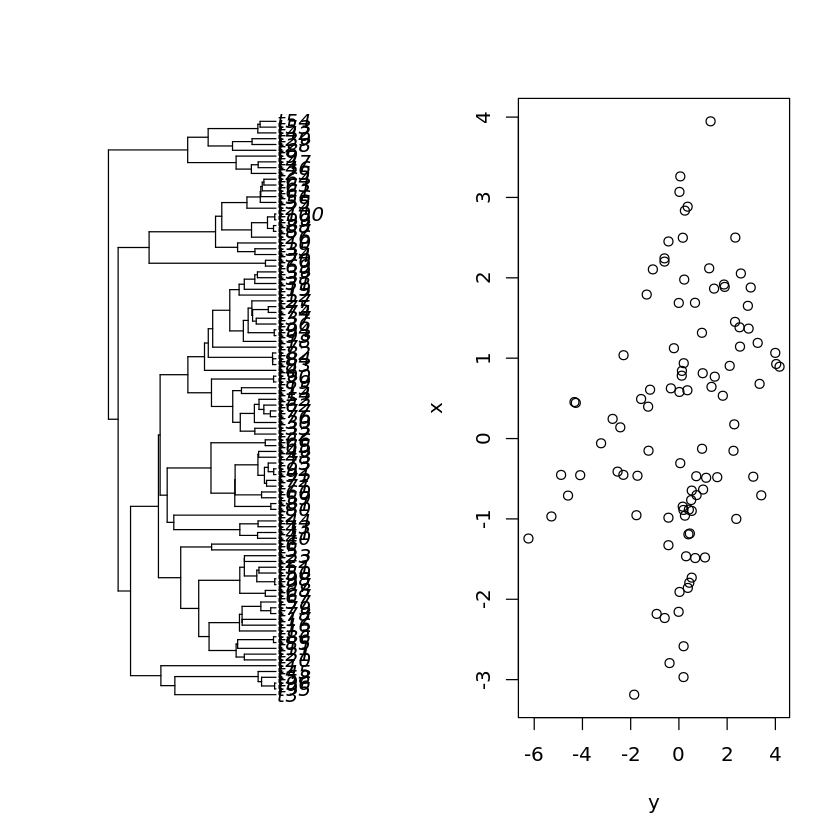

In [1]:
library(phytools)
library(geiger)

a=tr <- pbtree(n = 100)
dat <- sim.char(tr, matrix(c(1,0,0,1), 2, 2))[,,1]
colnames(dat) <- c('y', 'x')
#layout(matrix(c(1:2, 1, 2)))
par(mfrow = c(1,2))
plot(tr)
plot(dat)

You need the variance-covariance matrix of the tree:

In [2]:
tr.v <- vcv.phylo(tr)
round(tr.v[1:10, 1:10], 2) # shows just the upper lefthand corner of your matrix

,t3,t95,t96,t58,t45,t1,t20,t21,t11,t85
t3,4.48,1.78,1.78,1.78,1.78,1.40,0.59,0.59,0.59,0.59
t95,1.78,4.48,4.44,4.10,4.00,1.40,0.59,0.59,0.59,0.59
t96,1.78,4.44,4.48,4.10,4.00,1.40,0.59,0.59,0.59,0.59
t58,1.78,4.10,4.10,4.48,4.00,1.40,0.59,0.59,0.59,0.59
t45,1.78,4.00,4.00,4.00,4.48,1.40,0.59,0.59,0.59,0.59
t1,1.40,1.40,1.40,1.40,1.40,4.48,0.59,0.59,0.59,0.59
t20,0.59,0.59,0.59,0.59,0.59,0.59,4.48,3.63,3.42,3.42
t21,0.59,0.59,0.59,0.59,0.59,0.59,3.63,4.48,3.42,3.42
t11,0.59,0.59,0.59,0.59,0.59,0.59,3.42,3.42,4.48,3.46
t85,0.59,0.59,0.59,0.59,0.59,0.59,3.42,3.42,3.46,4.48


This becomes part of everything you do in generalized least squares. What can you do with it? You can invert it: the inverted matrix is that matrix that multiplied by the original (uninverted) matrix yields a matrix with diagonals of 1 and off-diagonals of 0:

In [3]:
round(solve(tr.v), 2)[1:10, 1:10]
round(solve(tr.v) %*% tr.v, 2)[1:10, 1:10]

,t3,t95,t96,t58,t45,t1,t20,t21,t11,t85
t3,0.28,-0.02,-0.02,-0.03,-0.04,-0.05,0.00,0.00,0.00,0.00
t95,-0.02,14.16,-13.31,-0.48,-0.32,-0.01,0.00,0.00,0.00,0.00
t96,-0.02,-13.31,14.16,-0.48,-0.32,-0.01,0.00,0.00,0.00,0.00
t58,-0.03,-0.48,-0.48,1.67,-0.61,-0.02,0.00,0.00,0.00,0.00
t45,-0.04,-0.32,-0.32,-0.61,1.36,-0.02,0.00,0.00,0.00,0.00
t1,-0.05,-0.01,-0.01,-0.02,-0.02,0.27,0.00,0.00,0.00,0.00
t20,0.00,0.00,0.00,0.00,0.00,0.00,0.84,-0.35,-0.17,-0.09
t21,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,0.84,-0.17,-0.09
t11,0.00,0.00,0.00,0.00,0.00,0.00,-0.17,-0.17,0.75,-0.12
t85,0.00,0.00,0.00,0.00,0.00,0.00,-0.09,-0.09,-0.12,7.76


,t3,t95,t96,t58,t45,t1,t20,t21,t11,t85
t3,1,0,0,0,0,0,0,0,0,0
t95,0,1,0,0,0,0,0,0,0,0
t96,0,0,1,0,0,0,0,0,0,0
t58,0,0,0,1,0,0,0,0,0,0
t45,0,0,0,0,1,0,0,0,0,0
t1,0,0,0,0,0,1,0,0,0,0
t20,0,0,0,0,0,0,1,0,0,0
t21,0,0,0,0,0,0,0,1,0,0
t11,0,0,0,0,0,0,0,0,1,0
t85,0,0,0,0,0,0,0,0,0,1


With the inverted matrix, you can weight your data by how phylogenetically distinct the corresponding tips are. To visualize these weights, multiply the inverted matrix by a column-matrix of ones (for example, `matrix(1, 10)` is a one-column matrix of 10 1s). You can visualize this using `phydataplot` from the `ape` package:

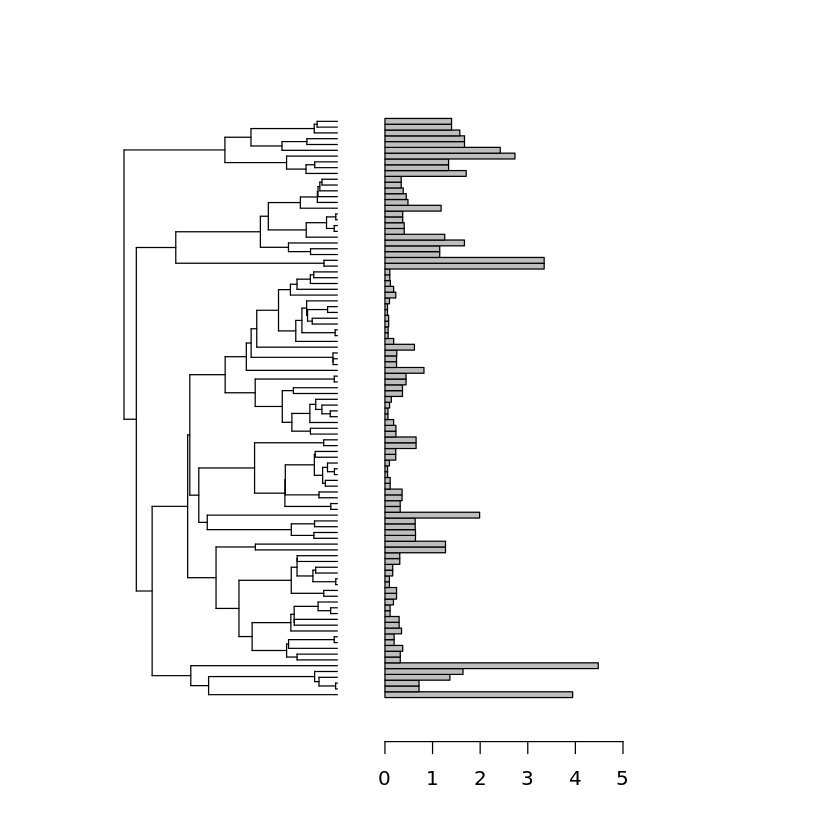

In [4]:
one <- matrix(1, length(tr$tip.label), 1) # a matrix of 1s, 1 column
tr.w <- t(one) %*% solve(tr.v)
a=plot(tr, show.tip.label = F, x.lim = nodeheight(tr,1) * 3) # sets the plot window width to be thrice the tree depth
phydataplot(tr.w[1,] / max(tr.w[1,]) * nodeheight(tr, 1), tr)

With this same machinery, you can compare the GLS estimate of regression coefficients with the OLS (ordinary least squares) estimates, using equations from Symonds and Blomberg Appendix A:

In [5]:
b.gls <- function(tr, dat, y = 'y', x = 'x') {
    #print(dat)
    v.solved <- solve(vcv.phylo(tr))
    one <- matrix(1, length(tr$tip.label))
    X <- cbind(origin = one, x = dat[, x])
    out <- solve(t(X) %*% v.solved %*% X) %*% (t(X) %*% v.solved %*% dat[, y])
    out
}

b.ols <- function(dat, y = 'y', x = 'x') {
    one <- matrix(1, dim(dat)[1])
    X <- cbind(origin = one, x = dat[, x])
    out <- solve(t(X) %*% X) %*% (t(X) %*% dat[, y])
    out
}
message('GLS coefficients (intercept and slope)')
b.gls(tr, dat)
message('OLS coefficients (intercept and slope)')
b.ols(dat)

GLS coefficients (intercept and slope)



,0.3910374
x,0.1969728


OLS coefficients (intercept and slope)



,0.1072074
x,0.3408429


In practice, you will probably find it easier to use one of the standard GLS functions. I typically use the `gls` function from the `nlme` package. The function requires a correlation structure, which can be pulled from the tree using the `corBrownian`, `corPagel`, or other correlation structures in `ape` (to see them all, use `?corClasses` in `R` with `ape` attached).

Revell and Symonds and Blomberg both discuss estimating phylogenetic signal simultaneously with the regression coefficients. This is really simple to do in R. Here is an example:

In [6]:
library(nlme)
out <- gls(y ~ x, as.data.frame(dat), corPagel(1, tr))
summary(out)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


Generalized least squares fit by REML
  Model: y ~ x 
  Data: as.data.frame(dat) 
       AIC      BIC    logLik
  280.0644 290.4042 -136.0322

Correlation Structure: corPagel
 Formula: ~1 
 Parameter estimate(s):
  lambda 
1.002509 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 0.3929765 0.8390549 0.4683561  0.6406
x           0.1924086 0.1072810 1.7935011  0.0760

 Correlation: 
  (Intr)
x -0.045

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-3.05261758 -0.49972573  0.01265505  0.41184173  1.72312764 

Residual standard error: 2.094323 
Degrees of freedom: 100 total; 98 residual

As an aside, folks do not agree about the use of R<sup>2</sup> in GLS regression. The problem is, as I understand it, at least in part that GLS regression is actually a regression on transformed data, so it's ambiguous what we mean by the amount of variance in `y` explained by `X`. But sometimes it's handy to report; I often do, but never on multiple GLS regression. The formula used here is from Judge et al. 1985, an econometrics text that is often cited for GLS. As I recall (I don't have the book in front of me now), Judge describes this as the R<sup>2</sup> on the transformed data projected back into the original coordinate space. Please don't quote me on this; I'm not sure I fully understand it. But this appears to be coded correctly, and I've used it plenty of times. In case you need it or want it, here it is:

In [7]:
gls.r.squared <- function(x) {
# based on Judge et al. 1985, eq. 2.3.16
  e = x$resid
  V <- corMatrix(x$modelStruct$corStruct)
  Y = x$resid + x$fitted
  one <- matrix(1, length(Y), 1)
  a <- as.numeric(solve(t(one) %*% solve(V) %*% one) %*% (t(one) %*% solve(V) %*% Y))
  r.squared= 1-(t(e) %*% solve(V) %*% e) / (t(Y-a) %*% solve(V) %*% (Y-a))
  return(r.squared[1,1])
  }

## example:
gls.r.squared(out) # probably will be pretty low, as we simulated data with no correlation

[1] 0.03177981

# Practice questions
1. Play around with the inverse of the covariance matrix (`tr.w <- t(one) %*% solve(tr.v)`) on different trees and see what taxa are upweighted more. What species contribute the most to the regression? Which weightings make sense, and which are surprising? You can use the code above and just run it for a handful of trees. Try your own data, if you have some.
2. Wrestle your own data into R or use the maple dataset we started working with on week 1, and use `gls` and `lm` to calculate regression coefficients. Try this in the traditional GLS / PIC manner using `corBrownian` for the correlation structure, and as Revell suggests, using `corPagel` and simulating lambda. What estimate of lambda do you get? how, if at all, does this affect your inferences?
2. Use formula #4 in Rohlf 2006 to calculate the phylogenetic mean (answer at the end of this tutorial). How is it different from the formula for the regression coefficients? Then, use that formula to estimate the mean for a randomly simulated trait on each of 500 randomly generated trees, each of 50 tips, with a root state of 0. Compare with the non-phylogenetic means for these. How do they compare? which gives the smaller variance? the lower bias?
3. Use the functions `lm` and `gls` OR the functions we generated for regression coefficients to compare the OLS and GLS slope on a Brownian-motion generated pair of traits on each of 500 randomly generated trees of 50 tips each, with a slope and root state of 0. How do they compare? which gives the smaller variance? the lower bias? 

## ANSWERS (NO PEEKING!)

### Challenge 2: phylogenetic means

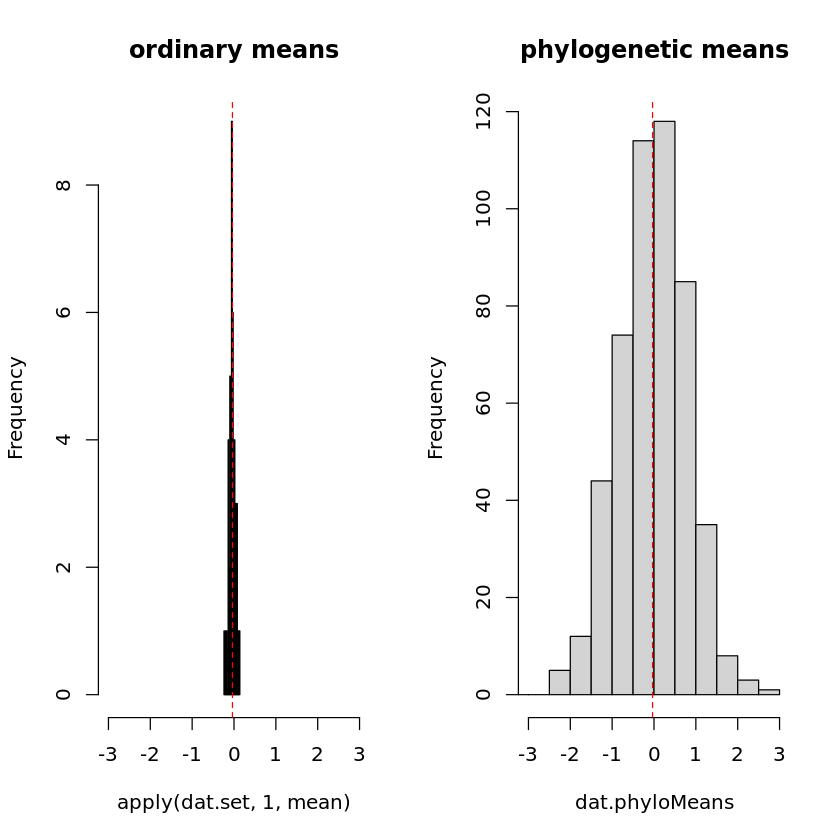

In [8]:
tr.set <- lapply(rep(1, 500), pbtree, n = 50)
dat.set <- sapply(tr.set, sim.char, par = 1, root = 0)
phylo.mean <- function(tr, dat) {
    #print(dat)
    v.solved = solve(vcv.phylo(tr))
    one = matrix(1, length(tr$tip.label))
    out = solve(t(one) %*% v.solved %*% one) %*% (t(one) %*% v.solved %*% dat)
    out
}
dat.phyloMeans <- sapply(1:length(tr.set), function(x) phylo.mean(tr.set[[x]], dat.set[, x]))
par(mfrow = c(1, 2))
hist(apply(dat.set, 1, mean), 20, main = 'ordinary means', xlim = c(-3, 3))
abline(v = mean(apply(dat.set, 1, mean)), col= 'red', lty = 'dashed')
hist(dat.phyloMeans, 20, main = 'phylogenetic means', xlim = c(-3, 3))
abline(v = mean(dat.phyloMeans), col = 'red', lty = 'dashed')

### Challenge 3: slope and intercept, OLS vs GLS


Call:
lm(formula = out$ols[, 2] ~ out$gls[, 2])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.10832 -0.18102  0.00137  0.16972  1.29687 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.001604   0.013424  -0.119    0.905    
out$gls[, 2]  0.730810   0.093572   7.810 3.41e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3002 on 498 degrees of freedom
Multiple R-squared:  0.1091,	Adjusted R-squared:  0.1073 
F-statistic:    61 on 1 and 498 DF,  p-value: 3.406e-14



Call:
lm(formula = out$ols[, 1] ~ out$gls[, 1])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81734 -0.28260  0.02219  0.27512  1.55814 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.006649   0.021843  -0.304    0.761    
out$gls[, 1]  0.981001   0.025854  37.944   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4884 on 498 degrees of freedom
Multiple R-squared:  0.743,	Adjusted R-squared:  0.7425 
F-statistic:  1440 on 1 and 498 DF,  p-value: < 2.2e-16


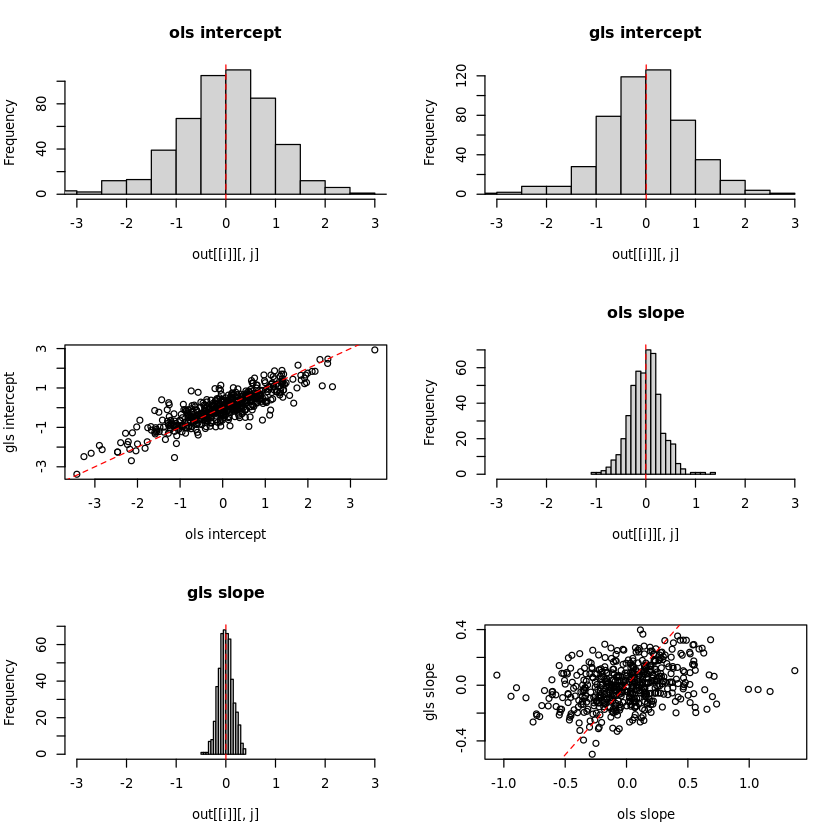

In [9]:
dat.set <- lapply(tr.set, sim.char, par = matrix(c(1, 0, 0, 1), 2, 2,), root = 0)
dat.set <- lapply(dat.set, function(x) x[,,1])

out <- list(ols = t(sapply(1:length(tr.set), function(i) b.ols(dat.set[[i]], y = 1, x = 2))),
             gls = t(sapply(1:length(tr.set), function(i) b.gls(tr.set[[i]], dat.set[[i]], y = 1, x = 2)))
                 )
colnames(out$ols) <- colnames(out$gls) <- c('intercept', 'slope')
                 
par(mfrow = c(3, 2)) # set up plotting area
                 
for(j in c('intercept', 'slope')) {
    for(i in c('ols', 'gls')) {
        hist(out[[i]][, j], 20, main = paste(i, j), xlim = c(-3, 3))
        abline(v = mean(out[[i]][, j]), col= 'red', lty = 'dashed')
    } # close i
    plot(out$ols[, j], out$gls[, j], xlab = paste('ols', j), ylab = paste('gls', j))
    abline(0, 1, col = 'red', lty = 'dashed')
  } # close j

summary(lm(out$ols[, 2] ~ out$gls[, 2]))
summary(lm(out$ols[, 1] ~ out$gls[, 1]))